Simulation Scenario #2 (Index 2 in the simulation_scenario document except with less variation)

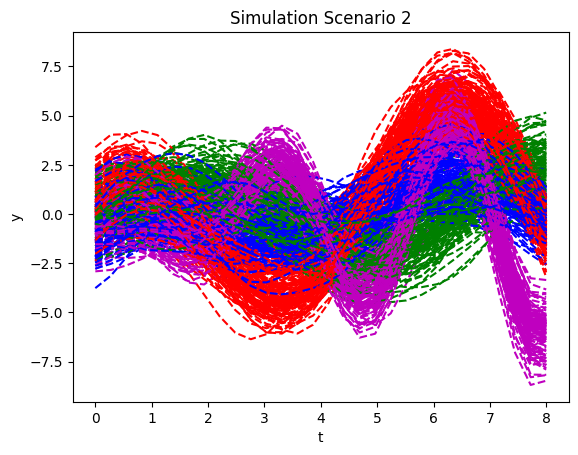

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate
import funEnsemble.functional_ensemble_clustering as ec
import fda_results as fr

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sample from the Gaussian process distribution
nb_of_samples = 30  # Number of points in each function
# Independent variable samples
t = np.expand_dims(np.linspace(0, 8, nb_of_samples), 1)
Σ = exponentiated_quadratic(t, t)  # Kernel of data points

# Create different curves
mean_curve = np.zeros((4, len(t)))
mean_curve[0] = np.reshape(np.sin(t)*np.log(t+2), (nb_of_samples))
mean_curve[1] = np.reshape(np.cos(t)*np.log(t+0.5), (nb_of_samples))
mean_curve[2] = np.reshape(np.cos(t)*(np.sqrt(5*t+0.5)), (nb_of_samples))
mean_curve[3] = np.reshape(np.cos(2*t)*np.log(t+0.5)*(np.sqrt(t+0.5)), (nb_of_samples))

mixture_k = [1/4, 1/4, 1/4, 1/4	]
n = 500
Y = np.zeros((n, len(t)))
simulation_label = np.zeros(n)

for i in range(n):
    # generate a random number between 0 and 1
    r = np.random.rand()
    # find the index of the mixture component
    if r < mixture_k[0]:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[0], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='g')
        # Remember the label of the component
        simulation_label[i] = 0

    elif r < mixture_k[0] + mixture_k[1]:
        # draw for the second component
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[1], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='b')
        # Remember the label of the component
        simulation_label[i] = 1

    
    elif r < mixture_k[0] + mixture_k[1] + mixture_k[2]:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[2], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='r')
        # Remember the label of the component
        simulation_label[i] = 2

    else:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[3], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='m')
        # Remember the label of the component
        simulation_label[i] = 3

plt.title('Simulation Scenario 2')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

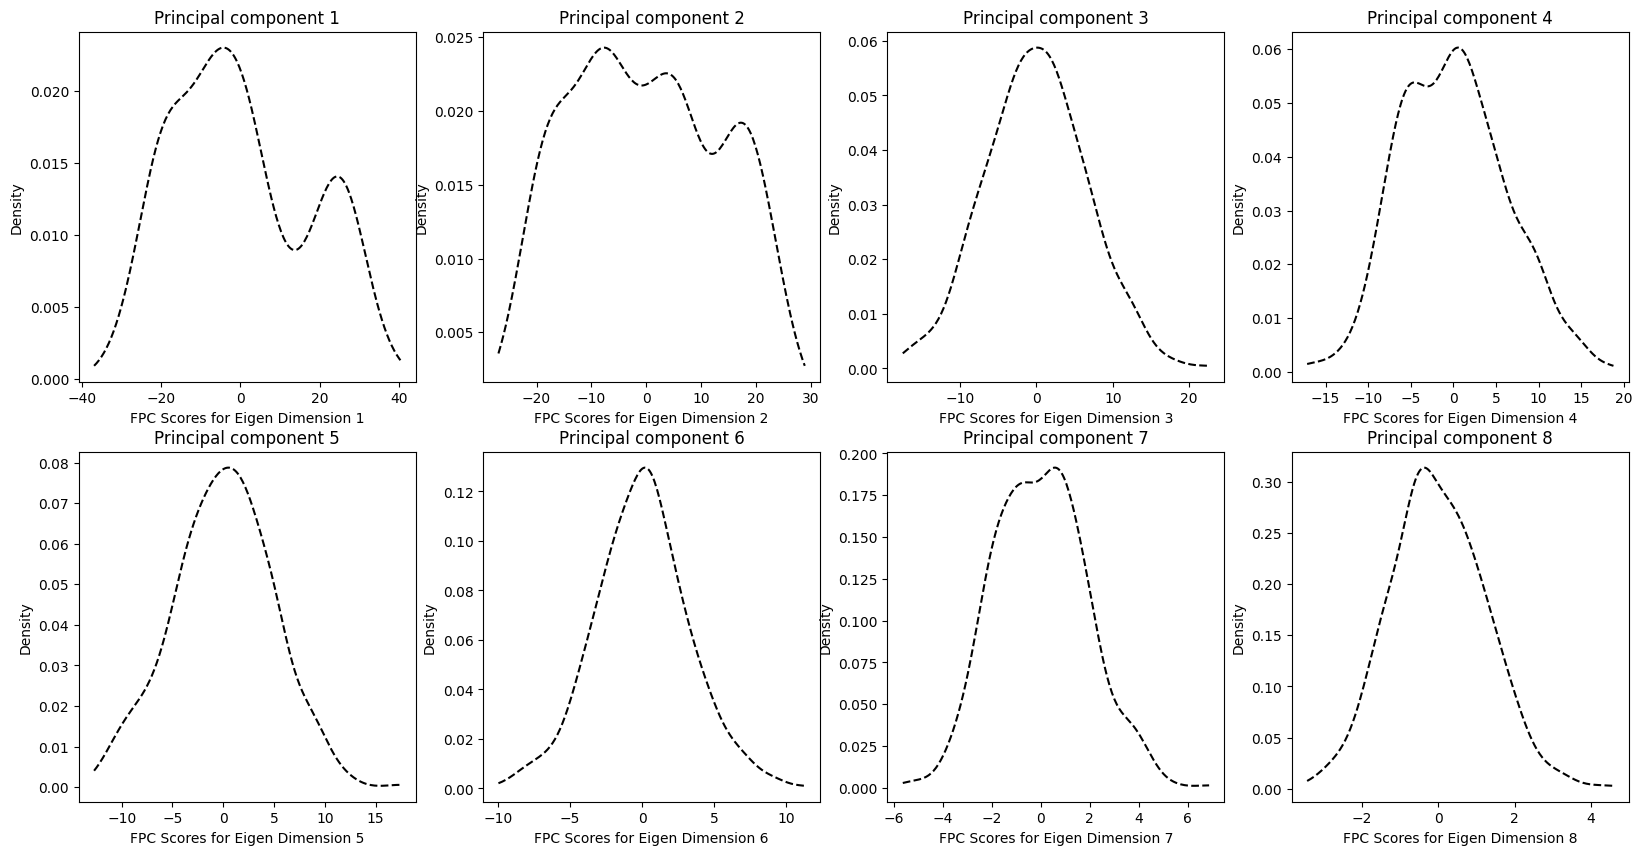

In [8]:
data_smooth, mean, principal_componenets, eigen_functions = ec.functional_data_decomposition(Y, 10, 150)

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
x = 0
for i in range(8):
        # Kernel density plot for principal components[i], as a scatter plot
        # Determine the desnity of principal components[i]
        kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
        # Create a grid of points
        x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 250)
        # Evaluate the density on the grid
        density = kde(x_grid)
        # Plot the density
        ax[x, i%4].plot(x_grid, density, linestyle='--', color='k')
        ax[x, i%4].set_title('Principal component ' + str(i+1))
        ax[x, i%4].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
        ax[x, i%4].set_ylabel('Density')
        if i%4 == 3:
                x = 1

plt.show()

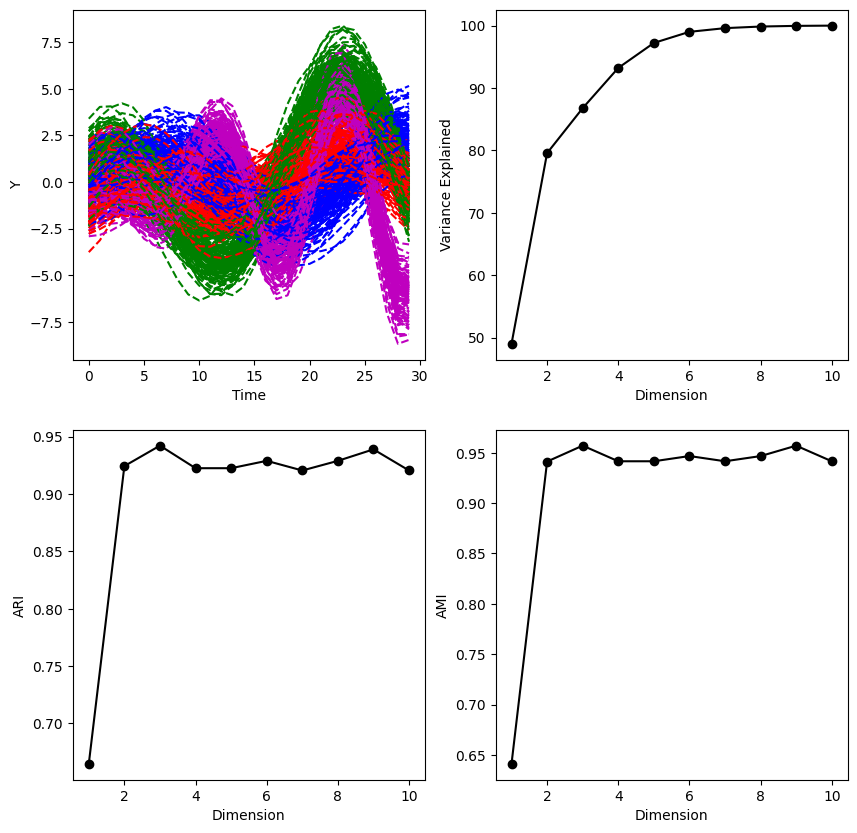

In [9]:
variance, ami, ari, v_range = fr.percentage_variation_ami_ari(10, Y, 150, simulation_label, 4)
fr.plot_percentage_variation_ami_ari(variance, ami, ari, v_range, simulation_label, Y)

In [10]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i))
        V = i -1
        if V == 0:
            V = 1
        break

The Eigen Dimension that explains 95% of the variance is 5


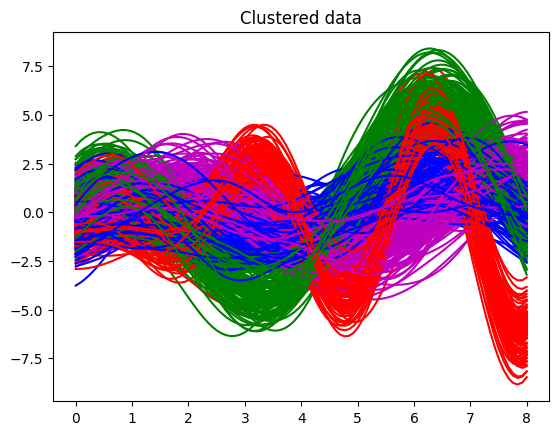

AMI score:
0.9225185882627893
ARI score:
0.9415402691671023


In [11]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = ec.functional_data_decomposition (Y, V, 100)

# Get data from the second function
membership_matrices, labels = ec.functional_data_clustering (principal_componenets, 4)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

# Get the AMI score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print("AMI score:")
print(adjusted_mutual_info_score(simulation_label, labels))

# Get the ARM score
from sklearn.metrics.cluster import adjusted_rand_score
print("ARI score:")
print(adjusted_rand_score(simulation_label, labels))

In [6]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(Y[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

data = DenseFunctionalData(t, Y)
# Build the tree
root_node = Node(data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(simulation_label, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(simulation_label, fcubt.labels_join))

ARI score for FCUBT: 0.926120
AMI score for FCUBT: 0.906754


In [7]:
# Store the data in DataStore.csv
np.savetxt('../Data/DataStore.csv', Y, delimiter=',')

In [8]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.2" # change as needed

%reload_ext rpy2.ipython

In [9]:
# Perform FunHDDC on the data

# Load packages
%R library(fda)
%R library(funHDDC)
%R library(mclust)
%R library(tidyverse)

# # Load data
%R argvals <- seq(0, 1, length.out = 30)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint

%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust <- funHDDC(data_fd, K = 4, threshold = 0.3, model = 'ABQkDk', itermax = 2000, eps = 1e-3, init = 'kmeans') # nolint
%R pred_labels <- res_clust$class

# %R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: fds

R[write to console]: Loading required package: rainbow

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: pcaPP

Exception ignored from cffi callback <function _callback at 0x00000191F2790670>:
Traceback (most recent call last):
  File "C:\Users\lukej\AppData\Roaming\Python\Python310\site-packages\rpy2\rinterface_lib\callbacks.py", line 330, in _callback
    callback()
  File "C:\Users\lukej\AppData\Roaming\Python\Python310\site-packages\rpy2\rinterface_lib\callbacks.py", line 319, in callback
    def callback() -> None:
KeyboardInterrupt: 
R[write to console]: Loading required package: RCurl

R[write to console]: Loading required package: deSolve

R[write to console]: 
Attaching package: 'fda'


R[write to console]: The following object is masked from 'package:graphics':

    matplot


R[write to console]: Registered S3 method ov

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 1.0.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::complete() masks RCurl::complete()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()
x purrr::map()      masks mclust::map()
x dplyr::select()   masks MASS::select()
   model K threshold complexity           BIC
1 ABQKDK 4       0.3        523 -2,385,446.92

SELECTED: model  ABQKDK  with  4  clusters.
Selection Criterion: BIC.


In [ ]:
# To simulate funHDDC, run run the R file funHDDC.R

# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('../Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(simulation_label, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(simulation_label, predicted_labels))

ARI score for funHDDC: 0.966136
AMI score for funHDDC: 0.950908


In [ ]:
# Load packages
%R library(fda)
%R library(funFEM)
%R library(mclust)
%R library(tidyverse)

# Load data
%R argvals <- seq(0, 1, length.out = 30)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint
%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust = funFEM(data_fd,K=4) # nolint # nolint: commas_linter.
%R pred_labels <- res_clust$P

# %R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint


       [,1] [,2] [,3] [,4]
  [1,]    1    0    0    0
  [2,]    1    0    0    0
  [3,]    1    0    0    0
  [4,]    0    0    1    0
  [5,]    1    0    0    0
  [6,]    0    1    0    0
  [7,]    0    0    0    1
  [8,]    0    0    1    0
  [9,]    0    0    1    0
 [10,]    1    0    0    0
 [11,]    1    0    0    0
 [12,]    1    0    0    0
 [13,]    0    1    0    0
 [14,]    0    0    1    0
 [15,]    1    0    0    0
 [16,]    1    0    0    0
 [17,]    1    0    0    0
 [18,]    1    0    0    0
 [19,]    1    0    0    0
 [20,]    1    0    0    0
 [21,]    0    1    0    0
 [22,]    0    0    1    0
 [23,]    1    0    0    0
 [24,]    1    0    0    0
 [25,]    0    0    1    0
 [26,]    0    0    1    0
 [27,]    0    0    0    1
 [28,]    0    0    1    0
 [29,]    1    0    0    0
 [30,]    0    1    0    0
 [31,]    0    0    1    0
 [32,]    1    0    0    0
 [33,]    0    0    1    0
 [34,]    1    0    0    0
 [35,]    1    0    0    0
 [36,]    0    0    1    0
 

In [ ]:
# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('../Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 5))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(simulation_label, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(simulation_label, labels))

ARI score for funFEM: 0.226956
AMI score for funFEM: 0.326382
